# SME0822 - Análise Multivariada e Aprendizado Não Supervisionado

Francisco Rosa Dias de Miranda - 4402962

Neste trabalho, faremos a análise do conjunto de dados Titanic, publicamente disponível no Kaggle. O objetivo é realizar a análise de componentes principais, k-vizinhos e discriminante linear do conjunto de dados, a fim de agrupar os atributos, identificando fatores importantes e criando regras de classificação para determinar se um indivíduo veio a óbito ou não.

In [254]:
# import data science libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import mlxtend as ml
import missingno as msno

A base de dados obtida possui um conjunto de treino e outro de teste, como o usual em problemas de ciência de dados. Faremos o ajuste do modelo no conjunto de treino

In [255]:
# import data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')


## Conjunto de Dados

O Titanic é um conjunto de dados amplamente conhecido que lista os passageiros que estavam a bordo do S.S. Titanic, assim como a informação se eles sobreviveram ou não ao desastre. Geralmente, esse conjunto de dados é utilizado em tarefas de classificação, aqui verificaremos também agrupamentos entre as variáveis.

In [256]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [257]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [258]:
chosen_vars = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train = train[chosen_vars]

Escolhemos utilizar um total de 6 variáveis observadas em 891 diferentes indivíduos:

  - `Survived` variável binária que indica se um indivíduo sobreviveu (1) ou não (0) ao naufrágio,
 - `PClass` variável categórica que indica a classe do passageiro (1,2 ou 3)
 - `Sbsp` Quantidade de irmãos / cônjuges a bordo do Titanic
 - `Parch` Quantidade de pais / crianças a bordo do Titanic
 - `Fare` Tarifa paga pelo Passageiro
 - `Embarked` Porto de Embarque (C = Cherbourg, Q = Queenstown, S = Southampton)
 - `Sex` indica o sexo de um indivíduo
 - `Age` indica a idade. Pode ser fracionada se menor que 1.

<AxesSubplot: >

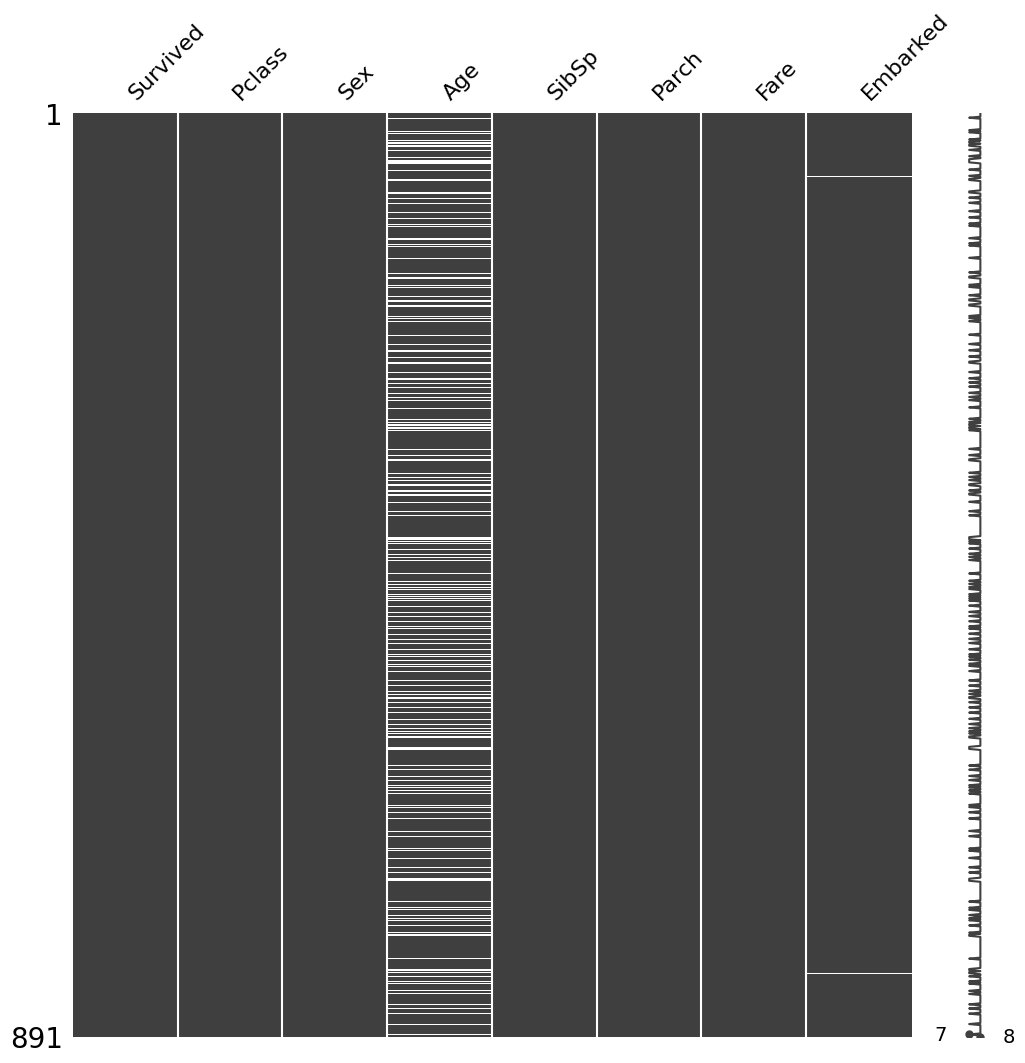

In [259]:
# missing data
msno.matrix(train, figsize=(12,12))

Com auxílio da biblioteca `missingno` verificamos a presença de valores faltantes nas variáveis `Age` e `Embark`. Esses valores poderão ter impacto na saída do ajuste, portanto um curso de ação para os dados faltantes é necessário.

## Preprocessamento

Nossa estratégia para os dados faltantes será substituí-los pela medina, pois ambas as variáveis com dados faltantes são numéricas discretas.

In [260]:
# DEAL WITH NANs

#inputing nan in Age
train['Age'].fillna(train['Age'].median(), inplace=True)

#inputing nan in Fare
train['Fare'].fillna(train['Fare'].median(), inplace=True)

Após o inputing dos dados faltantes, vamos transformar as variáveis categóricas em binárias, criando novas colunas para as novas categorias em nosso conjunto de dados.

In [261]:
# TRAIN
# dummy variables for embarked, pclass and sex  
embarked = pd.get_dummies(train['Embarked'], drop_first=True)
pclass = pd.get_dummies(train['Pclass'], drop_first=True)
sex = pd.get_dummies(train['Sex'], drop_first=True)

# select features
features = ['Age', 'SibSp', 'Parch', 'Fare']


# combine the dummy variables
X = pd.concat([train[features], embarked, pclass, sex], axis=1)
y = train['Survived']

T = pd.concat([X,y], axis=1)


## Análise Exploratória

Iniciamos a exploração dos dados com o auxílio de gráficos de barra de todas as variáveis escolhidas nas etapas anteriores.

array([[<AxesSubplot: title={'center': 'Survived'}>,
        <AxesSubplot: title={'center': 'Pclass'}>],
       [<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'SibSp'}>],
       [<AxesSubplot: title={'center': 'Parch'}>,
        <AxesSubplot: title={'center': 'Fare'}>]], dtype=object)

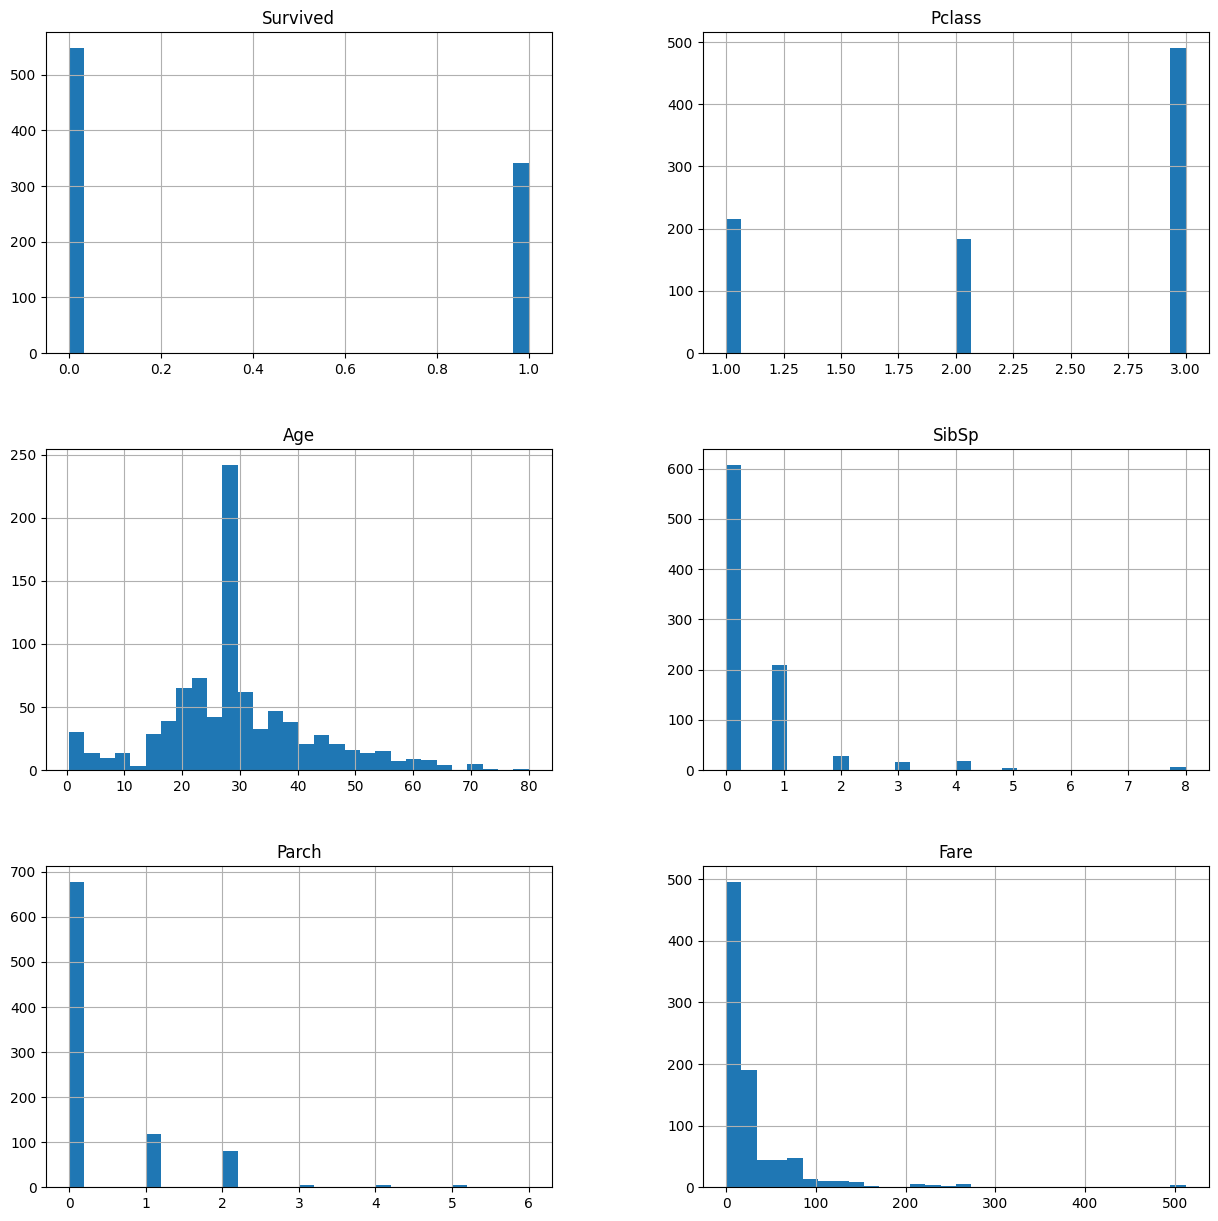

In [262]:
# barplots for numeric data
train.hist(figsize=(15,15), bins = 30)
           

In [263]:
# explore data
X.describe()

,Age,SibSp,Parch,Fare,Q,S,2,3,male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.361582,0.523008,0.381594,32.204208,0.086420,0.722783,0.206510,0.551066,0.647587
std,13.019697,1.102743,0.806057,49.693429,0.281141,0.447876,0.405028,0.497665,0.477990
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,1.000000,1.000000
75%,35.000000,1.000000,0.000000,31.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


Algumas considerações a respeito dos gráficos de barra:
 - A maioria dos passageiros (mais de 60%) não sobreviveu ao incidente
 - A maioria das pessoas é da terceira classe
 - A idade possui uma distribuição aparentemente assimétrica
 - 64% dos passageiros são do sexo masculino

<AxesSubplot: >

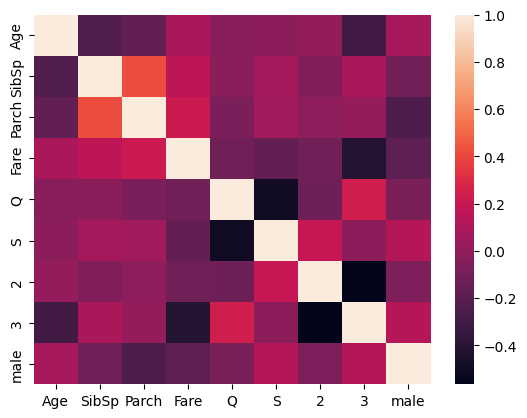

In [264]:
# variable correlation
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
            

Através do correlograma acima notamos uma alta correlação entre a classe e o preço da passagem, o que era esperado devido ao preço ser dependente da classe.

## Modelagem

### Parte 1: Análise de Componentes Principais 

A primeira etapa de nossa análise consiste em encontrar as componentes principais, a fim de reduzirmos a dimensionalidade e interpretar as combinações lineares. Como nossos dados não possuem distribuição normal, vamos normalizar as variáveis de nosso conjunto de dados.

In [265]:
from sklearn.preprocessing import StandardScaler

T.columns = T.columns.astype(str)
X.columns = X.columns.astype(str)

atr_names = X.columns

scaler = StandardScaler()
X_t = X
X = scaler.fit_transform(X)


Com os dados normalizados, vamos procurar a combinação de no máximo 7 componentes principais que junta seja capaz a variabilidade de nosso conjunto de dados.

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[7]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


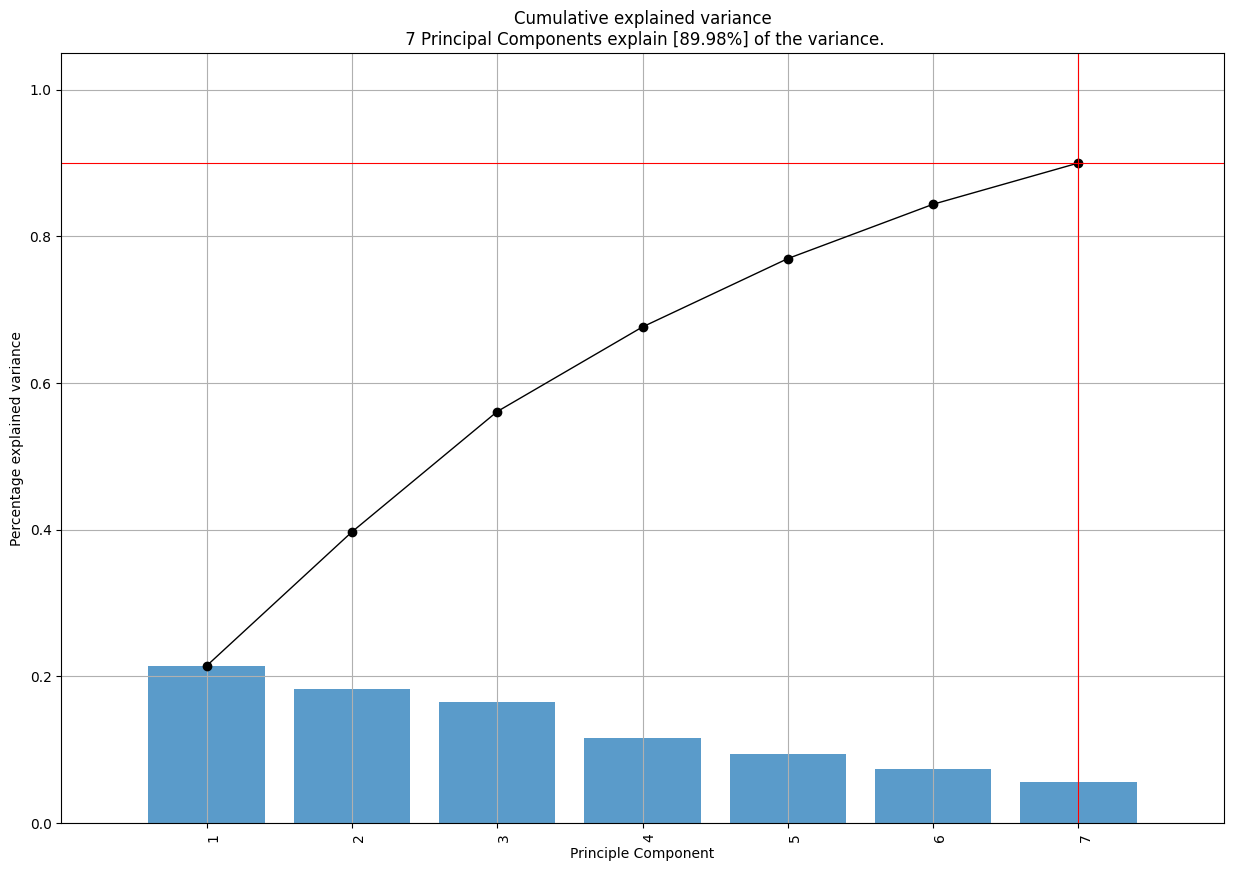

<Figure size 640x480 with 0 Axes>

In [266]:
from pca import pca

pca_fit = pca(n_components=7, normalize=True)

# Fit transform
results = pca_fit.fit_transform(T)

# Plot explained variance
fig, ax = pca_fit.plot()

# Scatter first 2 PCs
#fig, ax = model.scatter()

[pca] >Plot PC1 vs PC2 with loadings.


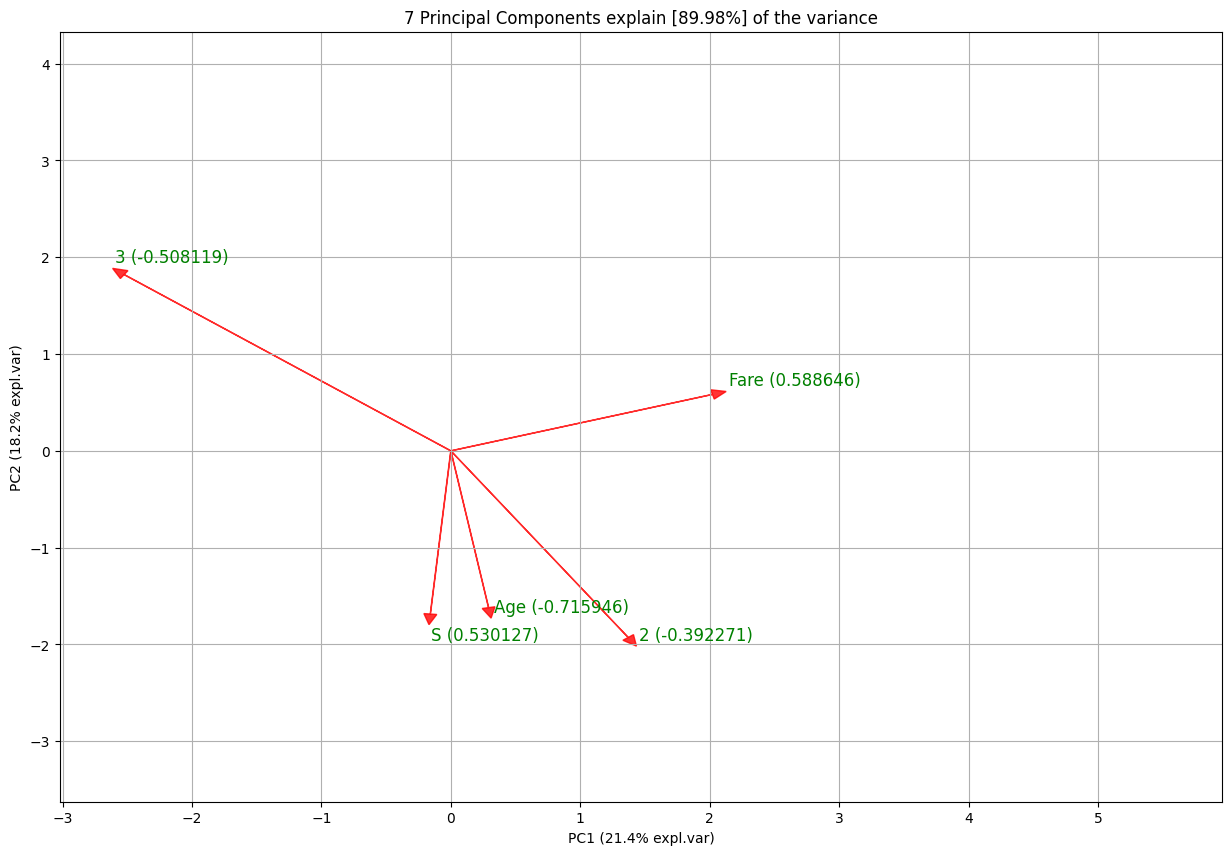

In [267]:
# Make biplot with the number of features
fig, ax = pca_fit.biplot(n_feat=5, legend= False, label = False, cmap= None)

#### Avaliando a separação

<AxesSubplot: >

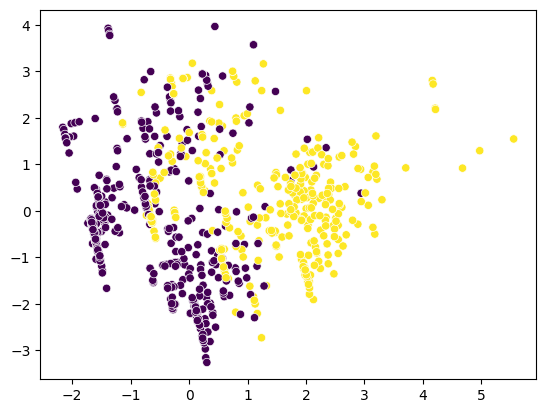

In [268]:
sns.scatterplot(x = fit[:,0], y= fit[:,1], c = y)

In [269]:
# loadings
print(pca_fit.results['loadings'])

          Age     SibSp     Parch      Fare         Q         S         2  \
PC1  0.060460  0.104395  0.233203  0.413539 -0.157114 -0.032818  0.278818   
PC2 -0.336001  0.341140  0.323005  0.119290  0.356348 -0.349097 -0.392271   
PC3 -0.291945  0.450284  0.414766 -0.035878 -0.441759  0.530127  0.069275   
PC4  0.453815  0.140250  0.106530  0.588646 -0.160499 -0.109821 -0.459831   
PC5  0.020877  0.363928  0.208672 -0.022134  0.436895 -0.289175  0.510984   
PC6 -0.715946 -0.056495 -0.337100  0.360687 -0.168211 -0.200506  0.012789   
PC7 -0.142804 -0.685400  0.672014  0.034807 -0.062267 -0.146383  0.049374   

            3      male  Survived  
PC1 -0.508119 -0.418070  0.472843  
PC2  0.366599 -0.300044  0.158159  
PC3  0.114066  0.074110 -0.198006  
PC4 -0.078788  0.303843 -0.262176  
PC5 -0.260474  0.275374 -0.379216  
PC6 -0.148632  0.382858  0.056263  
PC7  0.024380  0.113049 -0.126104  


In [270]:
# Print the top features.
print(pca_fit.results['topfeat'])

     PC   feature   loading  type
0   PC1         3 -0.508119  best
1   PC2         2 -0.392271  best
2   PC3         S  0.530127  best
3   PC4      Fare  0.588646  best
4   PC5         2  0.510984  best
5   PC6       Age -0.715946  best
6   PC7     SibSp -0.685400  best
7   PC7     Parch  0.672014  weak
8   PC3         Q -0.441759  weak
9   PC1      male -0.418070  weak
10  PC1  Survived  0.472843  weak


Aqui temos que a utilização de sete componentes principal conseguiu explicar cerca de 90% da fonte de variação total dos dados. Os atributos com maior carga dentre as componentes foram:

    - 2ª e 3ª classe: indivíduos com este atributo possuem menor chance de sobrevivência,
    - Indivíduos que embarcaram em Southhampton tiveram maior chance de sobrevivência,
    - Fare: quanto maior a tarifa paga, maior a chance de sobreviver.

### Parte 2: Análise discriminante e KNN

A LDA é um algoritmo de classificação que utiliza medidas descritivas dos grupos para determinar uma regra de decisão. Ela assume que os atributos são igualmente dispersos e normalmente distribuídos, assim como que os preditores são linearmente não correlacionados.

O KNN é um algoritmo que pode ser usado em tarefas de classificação, classificando um novo registro de acordo com seus k vizinhos mais próximos.

Em contraste com o PCA, o LDA é um método de aprendizado supervisionado, utilizando rótulos conhecidos no conjunto de treino. Já o KNN também pode ser usado em tarefas de segregação.

In [271]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec

In [272]:
# lda
clf1 = LDA()

lda_fit = clf1.fit_transform(X, y)


Os coeficientes da função discriminante linear são exibidos abaixo.

In [273]:
# bind X.columns, clf1.coef_
coef = pd.DataFrame(clf1.coef_, columns = atr_names)
print(coef)

        Age     SibSp     Parch      Fare         Q         S        2  \
0 -0.523979 -0.317739 -0.089717  0.122159 -0.012592 -0.217286 -0.40587   

          3      male  
0 -1.167774 -1.685809  


O valor discriminante é dado abaixo. Se somarmos a ele o valor do preditor linear estimado para uma nova observação e este for maior do que zero, classificamos o índivíduo como sobrevivente.

In [274]:
# discrimination threshold
print(clf1.intercept_)

[-0.79756315]


#### Escolha de k

Para ajustarmos o modelo KNN, primeiro escolheremos o melhor valor de k de acordo com sua capacidade de fazer previsões corretas de forma a minimizar os falsos positivos e verdadeiros negativos previstos pelo modelo.

Text(0.5, 0, 'Value of K for KNN')

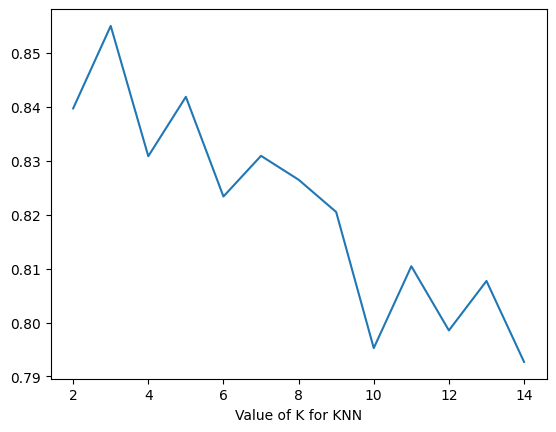

In [275]:
# auc according to k
k_range = range(2, 15)
scores = []
for k in k_range:
    knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    y_pred = knn.predict(X)
    scores.append(sk.metrics.roc_auc_score(y, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')


In [276]:
# best k
print(scores.index(max(scores)) + 2)

3


Agora que temos o melhor k, vamos ajustar o modelo.

In [277]:
clf2 = sk.neighbors.KNeighborsClassifier(n_neighbors=3)
knn_fit = clf2.fit(X, y)

In [278]:

# Chosing axes for decision regions
X_t = sk.preprocessing.StandardScaler().fit_transform(X_t[['Fare', 'Age']])


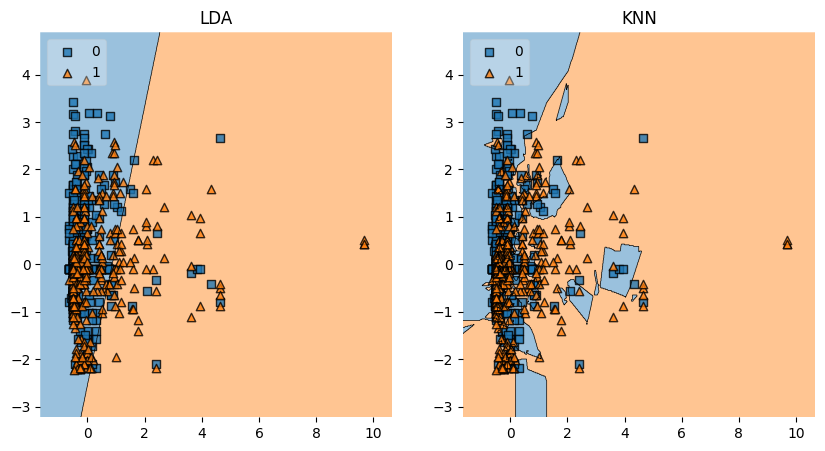

In [279]:
import itertools
# Plotting decision regions

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(10, 5))

labels = ['LDA', 'KNN']


for clf, lab, grd in zip([clf1, clf2], labels,
                         itertools.product([0, 1],
                         repeat=2)):

    clf.fit(X_t, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_t, y=np.array(y), clf=clf, legend=2)
    plt.title(lab)

plt.show()

In [280]:
# compare models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# LDA
scores = cross_val_score(clf1, X, y, cv=10, scoring='accuracy')
print(scores.mean())

# KNN
scores = cross_val_score(clf2, X, y, cv=10, scoring='accuracy')
print(scores.mean())


0.7901248439450687
0.7935830212234707


Os dois conjuntos de dados obtiveram acurácia similar na classificação do conjunto de treino.

## Referências

 - Ciência de Dados. Francisco Aparecido Rodrigues. https://github.com/franciscoicmc/ciencia-de-dados
 - PyCaret.org. PyCaret, April 2020. URL https://pycaret.org/about. PyCaret version 1.0.0.
 - Raschka, Sebastian (2018) MLxtend: Providing machine learning and data science utilities and extensions to Python's scientific computing stack. J Open Source Softw 3(24).
